In [1]:
import pandas as pd
import numpy as np
import re
import tqdm

from nltk import tokenize
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize 

from gensim.models import Word2Vec

from sklearn.model_selection import train_test_split

In [2]:
dataset=pd.read_csv('data/dataset.csv')

In [3]:
dataset.head()

,id,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [4]:
dataset["class"].unique()

array([2, 1, 0])

In [5]:
stop_words= set(stopwords.words('english'))

In [6]:
def clean_tweet(tweet):
    tweet = re.sub("#", "",tweet) # Removing '#' from hashtags
    tweet = re.sub("[^a-zA-Z#]", " ",tweet) # Removing punctuation and special characters
    tweet = re.sub(r'http[s]?://(?:[a-z]|[0-9]|[$-_@.&amp;+]|[!*\(\),]|(?:%[0-9a-f][0-9a-f]))+',"<URL>", tweet)
    tweet = re.sub('http','',tweet)
    tweet = re.sub(" +", " ", tweet)
    tweet = tweet.lower()
    tweet = word_tokenize(tweet)
    return_tweet=[]
    for word in tweet:
        if word not in stop_words:
            return_tweet.append(word)
    return return_tweet

In [7]:
dataset["tweet"]=dataset["tweet"].apply(clean_tweet)

## Word2Vec model to get the word embedings.

In [8]:
model = Word2Vec(dataset["tweet"].values, size=50, window=5, min_count=1, workers=4)

In [9]:
def get_features(tweet):
    features=[]
    for word in tweet:
        features.append(model.wv[word])
    return np.mean(features,0)


In [10]:
dataset["features"]=dataset["tweet"].apply(get_features)


In [11]:
data=[]
for i in dataset["features"].values:
    temp=[]
    for j in i:
        temp.append(j)
    data.append(temp)
data=np.array(data)

In [12]:
from sklearn.preprocessing import label_binarize

In [13]:
Y = label_binarize(dataset["class"].values, classes=[0, 1, 2])
n_classes = Y.shape[1]

In [14]:
X_train, X_test, y_train, y_test = train_test_split(data, Y, test_size=0.2, random_state=42)

# MODEL

In [15]:
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn import svm
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

## LOGISTIC REGRESSION MODEL

/home/lakshmeesravya/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/lakshmeesravya/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/lakshmeesravya/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


F1 Score:  0.845826853291861
Precision Score:  0.8700938566552902
Recall Score:  0.8228767399636877
Accuracy:  0.8224732701230583


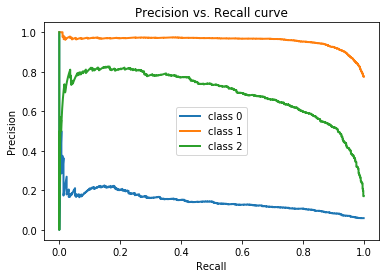

In [16]:
lr_clf = OneVsRestClassifier(LogisticRegression(random_state=0, solver='lbfgs',multi_class='multinomial'))
lr_clf.fit(X_train,y_train)
y_pred = lr_clf.predict(X_test)
f = f1_score(y_test, y_pred, average='micro')
print("F1 Score: ", f)
p = precision_score(y_test, y_pred, average='micro')
print("Precision Score: ", p)
r = recall_score(y_test, y_pred, average='micro')
print("Recall Score: ", r)
print("Accuracy: ", lr_clf.score(X_test,y_test))

y_score = lr_clf.predict_proba(X_test)
precision = dict()
recall = dict()
for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_test[:, i],
                                                        y_score[:, i])
    plt.plot(recall[i], precision[i], lw=2, label='class {}'.format(i))

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend(loc = "best")
plt.title("Precision vs. Recall curve")
plt.show()

## SVM MODEL

F1 Score:  0.8015499005131428
Precision Score:  0.8334059233449478
Recall Score:  0.7720395400443817
Accuracy:  0.7720395400443817


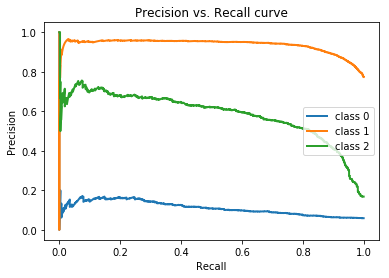

In [20]:
svm_clf = OneVsRestClassifier(svm.SVC(gamma='scale', probability=True))
svm_clf.fit(X_train,y_train)
y_pred = svm_clf.predict(X_test)
f = f1_score(y_test, y_pred, average='micro')
print("F1 Score: ", f)
p = precision_score(y_test, y_pred, average='micro')
print("Precision Score: ", p)
r = recall_score(y_test, y_pred, average='micro')
print("Recall Score: ", r)
print("Accuracy: ", svm_clf.score(X_test,y_test))

y_score = svm_clf.predict_proba(X_test)
precision = dict()
recall = dict()
for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_test[:, i],
                                                        y_score[:, i])
    plt.plot(recall[i], precision[i], lw=2, label='class {}'.format(i))

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend(loc = "center right")
plt.title("Precision vs. Recall curve")
plt.show()